In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from scipy.stats import entropy
import numpy as np

from load_moonboard import load_moonboard

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [23]:
parser = argparse.ArgumentParser()
parser.add_argument('--workers', type=int, help='number of data loading workers', default=0)
parser.add_argument('--batchSize', type=int, default=32, help='input batch size')
parser.add_argument('--imageSize', type=int, default=512, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=200, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=256)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=70, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0001, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')

opt = parser.parse_args([])

In [24]:
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True


"""Load the dataset"""
class MoonBoardDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train = True):
        self.train = train

        (self.x_train, self.y_train), (self.x_test, self.y_test) = load_moonboard()
        self.x_train = self.x_train.transpose(0,1,3,2 ).astype(float)
        self.x_test = self.x_test.transpose(0,1,3,2 ).astype(float)
        self.y_train = self.y_train.reshape(-1,1).astype(int)
        self.y_test = self.y_test.reshape(-1,1).astype(int)

    def __len__(self):
        if self.train:
            return len(self.x_train)
        else:
            return len(self.x_test)

    def __getitem__(self, idx):
        if self.train:
            return self.x_train[idx], self.y_train[idx]
        else:
            return self.x_test[idx], self.y_test[idx]

dataset = MoonBoardDataset(train = True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

nc = 3

Random Seed:  6417


In [25]:
print(torch.cuda.is_available())
device = torch.device("cuda")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)

True


In [26]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.convtrans1 = nn.ConvTranspose2d(nz, ngf * 4, (5,4), 2, 0, bias=False)
        self.convtrans2 = nn.ConvTranspose2d(ngf * 4, ngf * 2, (5,4), 2, 2, bias=False)
        self.convtrans3 = nn.ConvTranspose2d(    ngf * 2,      nc, (4,3), 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 4)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
   

    def forward(self, x):
        x = self.convtrans1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.convtrans2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.convtrans3(x)
        x = self.relu(x)
        
        x = self.tanh(x)
        
        return x


netG = Generator(ngpu).to(device)
netG.apply(weights_init)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.leakyRelu = nn.LeakyReLU(0.2, inplace=True)
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.conv1_1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv1_2 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, 1, (5,4), 2, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x,y):
        lbl = torch.zeros([x.shape[0],3,18,1]).to("cuda")
        x = torch.cat([x,lbl],3)
        for i,lbl in enumerate(y):
            x[i,2,lbl,11] = 1
        x = self.conv1_1(x)
        x = self.leakyRelu(x)
        
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.leakyRelu(x)
        
        x = self.conv3(x)
        
        return x.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)



Discriminator(
  (leakyRelu): LeakyReLU(negative_slope=0.2, inplace)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv1_2): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 1, kernel_size=(5, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (sigmoid): Sigmoid()
)

In [27]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=13):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
def inception_score(imgs, inception_model, splits = 1):

    N = len(imgs)    
    split_scores = []
    
    preds = nn.Softmax(dim = 1)(inception_model(imgs))
    
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = torch.mean(part, 0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx.cpu().detach().numpy(), py.cpu().detach().numpy()))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)
    
inception_model = torch.load("inception_model.trch")

In [28]:
criterion = nn.MSELoss()

fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

In [29]:
ff_noise = torch.randn(1000, nz, 1, 1, device=device)

print("Inception score ", inception_score(netG(ff_noise), inception_model))
best = 0
for epoch in range(opt.niter):
    for i, (x,y) in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = x.type(torch.FloatTensor).to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu,y)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz-13, 1, 1, device=device)
        y_fake = torch.randint(0,12,(batch_size,1))
        stck = torch.zeros([batch_size,13,1,1])
        for j,v in enumerate(y_fake):
            stck[j,v,0,0] = 1
        noise = torch.cat([stck.to("cuda"),noise.to("cuda")],1)
            
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach(),y_fake)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        for _ in range(2):
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            fake = netG(noise)
            output = netD(fake,y_fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, opt.niter, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end="\r")
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % opt.outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
                    normalize=True)
    print("")
    isc = inception_score(netG(ff_noise), inception_model)
    print("Inception score ", isc)
    
    if isc[0] > best:
        best = isc[0]
        torch.save(netG.state_dict(), 'bestG.pth')
        torch.save(netD.state_dict(), 'bestD.pth')


Inception score  (1.8143989, 0.0)
[0/70][129/130] Loss_D: 0.3860 Loss_G: 0.5628 D(x): 0.4148 D(G(z)): 0.2087 / 0.2498
Inception score  (1.9587616, 0.0)
[1/70][129/130] Loss_D: 0.1513 Loss_G: 0.4062 D(x): 0.6713 D(G(z)): 0.2080 / 0.36260
Inception score  (1.9516876, 0.0)
[2/70][129/130] Loss_D: 0.0960 Loss_G: 0.0113 D(x): 1.0152 D(G(z)): -0.3095 / 0.8939
Inception score  (1.8555907, 0.0)
[3/70][129/130] Loss_D: 0.0187 Loss_G: 1.5211 D(x): 0.9287 D(G(z)): 0.1169 / -0.2333
Inception score  (1.5218003, 0.0)
[4/70][129/130] Loss_D: 0.0474 Loss_G: 1.0490 D(x): 1.2177 D(G(z)): -0.0077 / -0.0242
Inception score  (2.0150893, 0.0)
[5/70][129/130] Loss_D: 0.0632 Loss_G: 0.1349 D(x): 0.8397 D(G(z)): -0.1936 / 0.6327
Inception score  (2.1037087, 0.0)
[6/70][129/130] Loss_D: 0.1101 Loss_G: 0.0678 D(x): 0.7311 D(G(z)): -0.1943 / 0.73957
Inception score  (1.668432, 0.0)
[7/70][129/130] Loss_D: 0.1073 Loss_G: 0.8084 D(x): 1.3140 D(G(z)): -0.0931 / 0.1009
Inception score  (1.8296229, 0.0)
[8/70][129/130

In [36]:
print("Inception score ", inception_score(next(iter(dataloader))[0].type(torch.FloatTensor).to(device), inception_model))
print(len(dataset))

Inception score  (2.4307632, 0.0)
4129


tensor([[ 4.2574,  0.5887,  0.1926,  0.2037, -0.0903, -0.3972, -0.3110, -0.4885,
         -0.6051, -0.6535, -0.6716, -0.8180, -0.8136]], device='cuda:0',
       grad_fn=<AddmmBackward>)
[ 3 11 18]


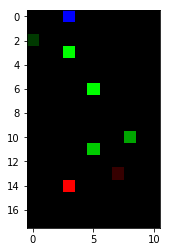

In [53]:
import matplotlib.pyplot as plt
noise = torch.randn(1, nz-13, 1, 1, device=device)
stck = torch.zeros([1,13,1,1])

stck[0,0,0,0] = 1

z_p = torch.cat([stck.to("cuda"),noise.to("cuda")],1)
        
z_p = z_p.to("cuda")
with torch.autograd.no_grad():
    x_p = netG(z_p)
#vutils.save_image(x_p.cpu(), "test.jpg",normalize=True)
print(inception_model(x_p))
print(np.flipud(np.swapaxes(np.swapaxes(x_p.view(3,18,11).data.cpu().numpy(),0,1),1,2).shape))
plt.imshow(np.flipud(np.swapaxes(np.swapaxes(x_p.view(3,18,11).data.cpu().numpy(),0,1),1,2)))
plt.savefig("img2017-7.png",dpi=300)

tensor([[ 2.6735,  0.6910,  0.4236,  0.7587,  0.1184, -0.1790, -0.0832, -0.3782,
         -0.6487, -0.7707, -0.8587, -1.0107, -0.9982]], device='cuda:0',
       grad_fn=<AddmmBackward>)


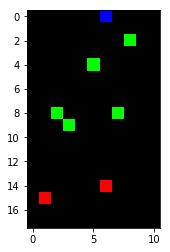

In [41]:
img = next(iter(dataloader))[0][0].view(-1, 3, 18, 11).type(torch.FloatTensor).to(device)
print(inception_model(img))
plt.imshow(np.flipud(np.swapaxes(np.swapaxes(img.view(3,18,11).data.cpu().numpy(),0,1),1,2)))